In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

# Regularized Regression Assignment (Ridge Regression vs LASSO)

In this assignment, we are going to train, evaluate, and compare two regularized regression model (Ridge Regression and LASSO) over Boston data to predict housing price.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/pararawendy/dibimbing-materials/refs/heads/main/boston.csv')
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


## Train, Validation, Test Split

Firstly, we divide the data into feature and target. Since the target of this model is predicting the housing price, the target data is the column `medv` and by dropping this column we obtain the feature data.


In [ ]:
feature = df.drop(columns='medv')
target = df[['medv']]

Next, we split the data into train and test data in which the train data will be splitted again into train and validation data. We want to make the proportion into 60%, 20%, 20% for train, validation, and test data respectively. Because from the first split we have 80% of the data, we need to calculate the test_size of the second split. Suppose that $x$ is the number of the data and $t$ is the test_size, then we should have $0.2x = t\times 0.8x$ such that $t=0.25$. Hence, the test_size for the second split is 0.25. Note that the percentage may lead to a decimal number of the data and thus it may yield to a slightly different number of the test and validation data.

In [ ]:
feature_train_val, feature_test, target_train_val, target_test = train_test_split(feature, target, test_size=0.20, random_state=42)

In [ ]:
feature_train, feature_val, target_train, target_val = train_test_split(feature_train_val, target_train_val, test_size=0.25, random_state=42)

In [ ]:
print(f'The length of feature_train is {len(feature_train)}')
print(f'The length of feature_val is {len(feature_val)}')
print(f'The length of feature_test is {len(feature_test)}')
print(f'The length of target_train is {len(target_train)}')
print(f'The length of target_val is {len(target_val)}')
print(f'The length of target_test is {len(target_test)}')

The length of feature_train is 303
The length of feature_val is 101
The length of feature_test is 102
The length of target_train is 303
The length of target_val is 101
The length of target_test is 102


## Correlation Plot and Feature Selection

We will attempt to detect the multicollinearity of the features by computing the Variance Inflation Factor (VIF).

In [ ]:
X = add_constant(feature) # here we use feature, i.e the whole feature data (not splitted yet) for analysis purpose

vif_df = pd.DataFrame([vif(X.values, i)
               for i in range(X.shape[1])],
              index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,crim,1.792192
2,zn,2.298758
3,indus,3.991596
4,chas,1.073995
5,nox,4.393720
6,rm,1.933744
7,age,3.100826
8,dis,3.955945
9,rad,7.484496
10,tax,9.008554


Based on this calculation, we should check the features `nox`, `rad`, and `tax` as they have `vif_score` $>4$. To check this, we have to visualize it using correlation heatmap. Here, we use the df again in order to calculate the correlation on the whole dataset entirely.

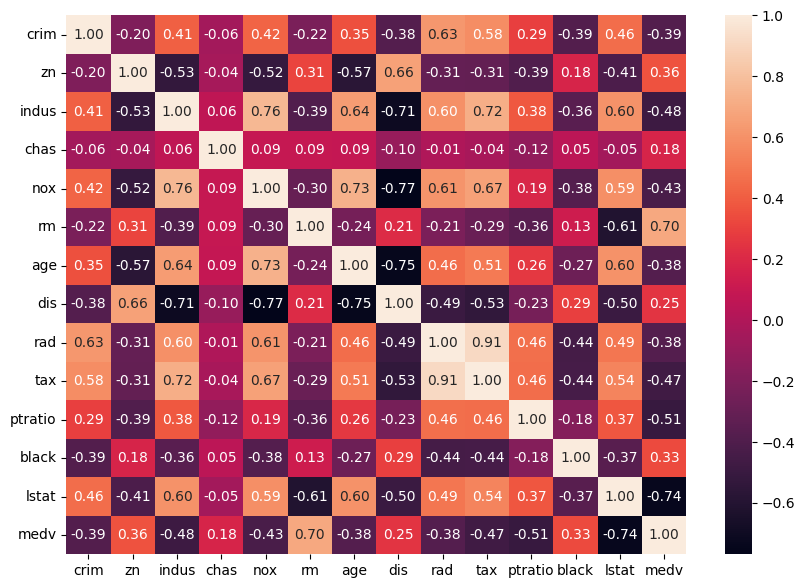

In [ ]:
corr = df.corr()

plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

In this analysis, we use the threshold as $|corr|\geq 0.8$. We attain that the features that have high correlation based on the threshold are merely `tax` and `rad` with $0.91$ correlation, indicating that we should drop one of these two features. After we check their correlation with `medv` we obtain that
$$
|corr(tax,medv)|=0.47>0.38=|corr(rad,medv)|.
$$
Thus, we decide to only include `tax` and drop `rad`.

In [ ]:
feature_train = feature_train.drop(columns=['rad'])
feature_val = feature_val.drop(columns=['rad'])
feature_test = feature_test.drop(columns=['rad'])

## Training Both Model and Choosing the Best Lambda

We prepare the data by converting them into numpy.

In [ ]:
X_train = feature_train.to_numpy()
y_train = target_train.to_numpy()
y_train = y_train.reshape(len(y_train),)

X_val = feature_val.to_numpy()
y_val = target_val.to_numpy()
y_val = y_val.reshape(len(y_val),)

In this process, we are going to train and validate the model over different lambdas, that is lambdas = [0.01, 0.1, 1, 10], and use RMSE as the metric. In every loop we will check the best RMSE for the models and we will save its score, corresponding lambda, and the trained model.

In [ ]:
lambdas = [0.01, 0.1, 1, 10]

rmse_ridge = []
rmse_lasso = []

# These are for checking the best RMSE. Since the smaller RMSE is the better the model will be, we set the first score as infinity.
rmse_best_ridge = np.inf
rmse_best_lasso = np.inf

best_lambda_ridge = 0
best_lambda_lasso = 0

for a in lambdas:
  # Ridge training process
  ridge_reg = Ridge(alpha=a, random_state=42)
  ridge_reg.fit(X_train, y_train)

  # Ridge predicting process and scoring
  y_pred = ridge_reg.predict(X_val)
  score = np.sqrt(mean_squared_error(y_val,y_pred))
  rmse_ridge.append(score)

  # selecting the best ridge model
  if score < rmse_best_ridge:
    best_ridge = ridge_reg # saving the best model
    rmse_best_ridge = score # saving the best RMSE
    best_lambda_ridge = a # saving the best lambda

  # Lasso training process
  lasso_model = Lasso(alpha=a, random_state=42)
  lasso_model.fit(X_train, y_train)

  # Lasso predicting process and scoring
  y_pred = lasso_model.predict(X_val)
  score = np.sqrt(mean_squared_error(y_val,y_pred))
  rmse_lasso.append(score)

  # selecting the best lasso model
  if score < rmse_best_lasso:
    best_lasso = lasso_model
    rmse_best_lasso = score
    best_lambda_lasso = a

result = pd.DataFrame({'Lambda':lambdas, 'Ridge RMSE':rmse_ridge, 'Lasso RMSE':rmse_lasso})
display(result)
print(f'The best Ridge RMSE is {rmse_best_ridge} at lambda = {best_lambda_ridge}')
print(f'The best Lasso RMSE is {rmse_best_lasso} at lambda = {best_lambda_lasso}')

,Lambda,Ridge RMSE,Lasso RMSE
0,0.01,4.862717,4.845211
1,0.10,4.854310,4.868554
2,1.00,4.834227,5.113860
3,10.00,4.839840,6.043327


The best Ridge RMSE is 4.834227357105801 at lambda = 1
The best Lasso RMSE is 4.8452109433019555 at lambda = 0.01


Based on the results above, we obtain that the best lambda for Ridge model is 1 with RMSE score $\approx 4.83$ on validation data while the best lambda for Lasso is 0.01 with RMSE score $\approx 4.85$ on validation data. Therefore, in this case, the best Ridge model is slightly better than the best Lasso model because we have $4.83 < 4.85$. Next, we will see the coefficient of the features for both model.

In [ ]:
coef_df = pd.DataFrame({
    'feature':['intercept'] + feature_train.columns.tolist(),
    'coefficient ridge':[best_ridge.intercept_] + list(best_ridge.coef_),
    'coefficient lasso':[best_lasso.intercept_] + list(best_lasso.coef_)
})

coef_df

,feature,coefficient ridge,coefficient lasso
0,intercept,16.732978,20.818684
1,crim,-0.065887,-0.068616
2,zn,0.032136,0.029642
3,indus,-0.031643,-0.008921
4,chas,2.893318,3.075747
5,nox,-8.712630,-14.610871
6,rm,4.973903,4.954930
7,age,-0.005527,-0.001614
8,dis,-1.386749,-1.474314
9,tax,-0.001724,-0.000650


The sign of the coefficients indicates the direction of the feature compare to the target. This means that the positive sign indicates that when the value of the feature increases, the target variable will aso increase. On the contrary, the negative sign shows that the reduction of the value of the feature will lead to the increment of the target variable. In this case, nox has negative coefficient resulting that when nox declines, the housing price will incline.

Furthermore, the magnitude of the coefficient indicates how large the impact of the change of the feature value is toward the target variable. Higher value will greatly influence the change of the target variable and vice versa. Here, we attain that nox has the largest magnitude in both model, which means that nox is the most impactful factor for the housing price, i.e. a slight difference of the value will yield to high alteration of the target variable.

## Model Evaluation

### Ridge Evaluation

In [ ]:
# Train dataset
y_pred = best_ridge.predict(X_train)
train_error = []

mae_train = mean_absolute_error(y_train, y_pred)
train_error.append(mae_train)

mape_train = mean_absolute_percentage_error(y_train, y_pred)
train_error.append(mape_train)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred))
train_error.append(rmse_train)

# Test dataset
X_test = feature_test.to_numpy()
y_test = target_test.to_numpy()
y_test = y_test.reshape(len(y_test),)

y_pred = best_ridge.predict(X_test)
test_error = []

mae_test = mean_absolute_error(y_test, y_pred)
test_error.append(mae_test)

mape_test = mean_absolute_percentage_error(y_test, y_pred)
test_error.append(mape_test)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
test_error.append(rmse_test)

error_df = pd.DataFrame({'Metric': ['MAE', 'MAPE', 'RMSE'], 'Train Dataset':train_error, 'Test Dataset':test_error})
error_df

,Metric,Train Dataset,Test Dataset
0,MAE,3.352264,3.320891
1,MAPE,0.166755,0.180453
2,RMSE,4.724030,5.196011


The MAPE score is in the form of percentage so we can easily interpret its results. However, at glance, the MAE and RMSE of both dataset seems high but remember that we should consider the range of the data and/or its unit. Thus, we have to check it by using the following code.

In [ ]:
df.describe().medv

,medv
count,506.000000
mean,22.532806
std,9.197104
min,5.000000
25%,17.025000
50%,21.200000
75%,25.000000
max,50.000000


We have that the minimum value of `medv` is 5 and the maximum is 50.  Hence, the MAE and RMSE of the train dataset at 3.35 and 4.72 are acceptable as they are relatively small. Moreover, since the discrepancy of these values with the values of the same metrices in the test dataset are small, we conclude that that the model is neither overfit nor underfit. Likewise, we also have the MAPE of both dataset are good enough and not so much different. Therefore, we decide that this model is just right based on the three metrices.

### Lasso Evaluation

In [ ]:
# Train dataset
y_pred = best_lasso.predict(X_train)
train_error = []

mae_train = mean_absolute_error(y_train, y_pred)
train_error.append(mae_train)

mape_train = mean_absolute_percentage_error(y_train, y_pred)
train_error.append(mape_train)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred))
train_error.append(rmse_train)

# Test dataset
y_pred = best_lasso.predict(X_test)
test_error = []

mae_test = mean_absolute_error(y_test, y_pred)
test_error.append(mae_test)

mape_test = mean_absolute_percentage_error(y_test, y_pred)
test_error.append(mape_test)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
test_error.append(rmse_test)

error_df = pd.DataFrame({'Metric': ['MAE', 'MAPE', 'RMSE'], 'Train Dataset':train_error, 'Test Dataset':test_error})
error_df

,Metric,Train Dataset,Test Dataset
0,MAE,3.349269,3.367499
1,MAPE,0.166070,0.182581
2,RMSE,4.699267,5.192707


Similarly, all of the metrices show small value both in train and test dataset. In addition, the difference between the value of the metrices in both dataset are also small. Thus, we conclude that the Lasso model is neither overfit nor underfit in this dataset.

If we compare the MAE and MAPE score over test dataset for Ridge and Lasso model, we attain that Ridge is better than Lasso because the value of both metrices are smaller, i.e $3.32 < 3.37$ for MAE score and $0.180 < 0.183$ for MAPE score. Nevertheless, the RMSE score yields a different conclusion, we have that the RMSE of Ridge over test dataset is slightly larger than the RMSE of Lasso over test dataset, i.e $5.196 > 5.192$. To sum up the result, we can take a vote from the three metrices and deduce further the difference of the score in both model. As two out of three metrices point out that Ridge is better than Lasso and the last metric (RMSE) yields in a tiny discrepancy at approximately 0.004, we decide that the Ridge model is better than Lasso model in this study case.